# Evaluation

In this notebook several models will be trained and then evaluate in order to measure of how effectively they predict instances of fraud using data based on (https://www.kaggle.com/dalpozz/creditcardfraud).
 
__Info about the dataset__:
Each row in `fraud_data.csv` corresponds to a credit card transaction. The features are confidential from variables `V1` through `V28`. In addition, there is `Amount` which is the amount of the transaction. 
 
The target data is stored in the `class` column, where a value of 1 corresponds to *fraud* and 0 means *no fraud*.

## Import Libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Import Dataset

First, let's have a look at the class distribution of fraud vs. no fraud

In [2]:
def fraud_classes():
    
    df = pd.read_csv('other/fraud_data.csv')
    count = np.bincount(df.Class)
    print(f"there are: {count[0]} zeros: NO FRAUD and {count[1]} 1: FRAUD")
    perc = count[1]/(count[0]+count[1])
    return perc

fraud_classes()

there are: 21337 zeros: NO FRAUD and 356 1: FRAUD


0.016410823768035772

Again, we implement some code for train and test split

In [8]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('other/fraud_data.csv')

X = df.iloc[:,:-1] # All rows and all columns except the last one
y = df.iloc[:,-1] # All rows andand the last column -> label
    
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    

In order to have a reference score for the later implemented classifier, we will implement a dummy classifier that classifies everything as the majority class of the training data. In that sense, we will focus on the accuracy of and the recall of this classifier?



In [10]:
def dummy_cl():
    from sklearn.dummy import DummyClassifier
    from sklearn.metrics import recall_score, accuracy_score
    
    dummy_clf = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
    dummy_pred = dummy_clf.predict(X_test) 
    recall = recall_score(y_test, dummy_pred)
    accuracy = accuracy_score(y_test, dummy_pred)
    
    return (accuracy, recall)

dummy_cl()

(0.9852507374631269, 0.0)

In a next step, a SVC with parameters `{'C': 1e9, 'gamma': 1e-07}` will be implemented. In order to evaluate the classifier better, we compute the confusion matrix while using a threshold of -220 on the decision function.

In [11]:
def svc_confusion():
    from sklearn.metrics import confusion_matrix
    from sklearn.svm import SVC
    
    svc_clf = SVC(C=1e9, gamma=1e-07).fit(X_train, y_train)
    y_svc_pred = svc_clf.decision_function(X_test) > -220
    confusion = confusion_matrix(y_test, y_svc_pred)
    
    return  confusion 

svc_confusion()

array([[5320,   24],
       [  14,   66]])

Now, we train LogReg classifier with default parameters using X_train and y_train. For the classifier, we create a precision-recall curve and a roc curve using y_test. What is the recall at a precision of `0.75`?

Looking at the roc curve, what is the true positive rate when the false positive rate is `0.16`?


/Users/vincentvonburen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vincentvonburen/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


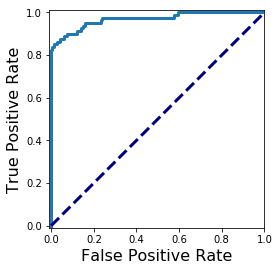

In [13]:



def curve_val_roc():
    
    from sklearn.metrics import precision_recall_curve, roc_curve, auc
    from sklearn.linear_model import LogisticRegression
        
    lr_clf = LogisticRegression().fit(X_train, y_train)
    y_proba_lr = lr_clf.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba_lr[:,1])
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr[:,1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    
    
    plt.figure()

    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.plot(precision, recall, label='Precision-Recall Curve')
    plt.xlabel('Precision', fontsize=16)
    plt.ylabel('Recall', fontsize=16)
  
    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
    
    return 


curve_val_roc()

In order to determine the best parameters for our LogReg model, we perform a greid search over the parameters listed below. In addition, we will be using recall for scoring and the default 3-fold cross validation.

`'penalty': ['l1', 'l2']`

`'C':[0.01, 0.1, 1, 10, 100]`


In [24]:
def grid_search():    
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import LogisticRegression
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

    lr_reg = LogisticRegression()
    grid_values = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

    grid_lr_recall = GridSearchCV(lr_reg, param_grid = grid_values, scoring='recall')
    grid_lr_recall.fit(X_train, y_train)
    
    return grid_lr_recall.cv_results_['mean_test_score']

grid_search()

array([0.66666667, 0.76086957, 0.80072464, 0.80434783, 0.8115942 ,
       0.8115942 , 0.80797101, 0.8115942 , 0.80797101, 0.80797101])

In order to have a better understanding of the results, we will use a heatmap which illustrates the different parameter combinations.

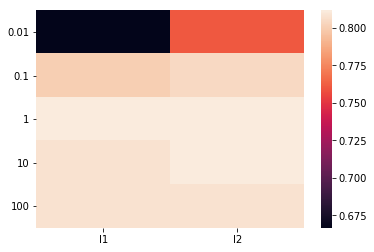

In [25]:
def GridSearch_Heatmap(scores):
    import seaborn as sns
    plt.figure()
    sns.heatmap(scores.reshape(5,2), xticklabels=['l1','l2'], yticklabels=[0.01, 0.1, 1, 10, 100])
    plt.yticks(rotation=0);

GridSearch_Heatmap(grid_search())